### Bandpass Filtering  
  
The first time around, I began with settings for the bandpass filter of 1 Hz and 70 Hz because of the recommendations from Learning EEG, but I've decided it's better to make my adjustments to the filters with the other at its default setting rather than starting from the Learning EEG recommendation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fastparquet, pyarrow
import mne
from mne.decoding import Scaler
from mne_features.univariate import compute_pow_freq_bands
from utils import *

In [2]:
mne.set_log_level('WARNING')

In [3]:
df = pd.read_csv('by_patient.csv')

In [4]:
other_df = activity_df(df, 'Other', 'expert_consensus')
seizure_df = activity_df(df, 'Seizure', 'expert_consensus')
lpd_df = activity_df(df, 'LPD', 'expert_consensus')
gpd_df = activity_df(df, 'GPD', 'expert_consensus')
lrda_df = activity_df(df, 'LRDA', 'expert_consensus')
grda_df = activity_df(df, 'GRDA', 'expert_consensus')

In [5]:
activity_df_list = [other_df, seizure_df, gpd_df, lpd_df, grda_df, lrda_df]

In [6]:
bandpass_df = pd.read_csv('bandpass_df.csv')

In [7]:
#bandpass_df = full_band_df(2000, activity_df_list, 1, 70, notch = False)

In [8]:
bandpass_df.shape

(12000, 95)

In [9]:
y_true = get_yvals(2000)

In [10]:
#bandpass_df.to_csv('bandpass_df.csv', index = None)

In [33]:
X1 = pd.read_csv('bandfeatures_12000.csv')
X2 = bandpass_df

In [34]:
X1 = X1.drop(columns = ['activity']).copy()
y1  = y_true['activity'].copy()
y2 = y_true['activity'].copy()

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [36]:
skl_scaler = StandardScaler()
X1 = skl_scaler.fit_transform(X1)

skl_scaler2 = StandardScaler()
X2 = skl_scaler2.fit_transform(X2)

In [37]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.1, random_state = 42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.1, random_state = 42)

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score

### Before Bandpass Filtering

In [39]:
knn = KNeighborsClassifier()
knn.fit(X1_train, y1_train)
training_yhat1 = knn.predict(X1_train)
testing_yhat1 = knn.predict(X1_test)
print('Training')
print(classification_report(y1_train, training_yhat1))
print('Testing')
print(classification_report(y1_test, testing_yhat1))

Training
              precision    recall  f1-score   support

         GPD       0.81      0.92      0.86      1794
        GRDA       0.72      0.87      0.79      1819
         LPD       0.75      0.87      0.80      1800
        LRDA       0.80      0.87      0.83      1795
       Other       0.76      0.53      0.62      1808
     Seizure       0.86      0.60      0.71      1784

    accuracy                           0.78     10800
   macro avg       0.78      0.78      0.77     10800
weighted avg       0.78      0.78      0.77     10800

Testing
              precision    recall  f1-score   support

         GPD       0.72      0.85      0.78       206
        GRDA       0.56      0.76      0.65       181
         LPD       0.63      0.71      0.67       200
        LRDA       0.65      0.76      0.70       205
       Other       0.64      0.41      0.50       192
     Seizure       0.74      0.44      0.55       216

    accuracy                           0.65      1200
   mac

In [41]:
nofilter_train, nofilter_test = accuracy_score(y1_train, training_yhat1), accuracy_score(y1_test, testing_yhat1)

In [43]:
nofilter_train.round(decimals = 3), nofilter_test.round(decimals = 3)

(0.776, 0.653)

### After Bandpass Filtering

In [21]:
knn = KNeighborsClassifier()
knn.fit(X2_train, y2_train)
training_yhat2 = knn.predict(X2_train)
testing_yhat2 = knn.predict(X2_test)
print('Training')
print(classification_report(y2_train, training_yhat2))
print('Testing')
print(classification_report(y2_test, testing_yhat2))

Training
              precision    recall  f1-score   support

         GPD       0.79      0.91      0.85      1803
        GRDA       0.76      0.88      0.81      1803
         LPD       0.75      0.87      0.80      1792
        LRDA       0.83      0.89      0.86      1788
       Other       0.76      0.54      0.63      1807
     Seizure       0.87      0.63      0.73      1807

    accuracy                           0.79     10800
   macro avg       0.79      0.79      0.78     10800
weighted avg       0.79      0.79      0.78     10800

Testing
              precision    recall  f1-score   support

         GPD       0.67      0.85      0.75       197
        GRDA       0.67      0.79      0.73       197
         LPD       0.66      0.77      0.71       208
        LRDA       0.80      0.78      0.79       212
       Other       0.56      0.42      0.48       193
     Seizure       0.77      0.50      0.61       193

    accuracy                           0.69      1200
   mac

### Initial Notes on Results  
  
I had to run the above code again. I got a 3% testing accuracy improvement the first few times I ran it and then a 1% improvement. This most recent run shows no change in testing accuracy before and after bandpass filtering with a bandpass filter set at 1 Hz and 70 Hz.  
  
### Highpass Filtering

In [28]:
#highpass_vals = [0.5, 1.0, 1.5, 2.0]
#for i in range(len(highpass_vals)):
#    feature_df = full_band_df(2000, activity_df_list, highpass_vals[i], None, bandpass = True, notch = False, reref = False)
#    feature_df.to_csv('highpass_features_{}.csv'.format(i), index = None)

In [50]:
X0 = pd.read_csv('highpass_features_0.csv')
X1 = pd.read_csv('highpass_features_1.csv')
X2 = pd.read_csv('highpass_features_2.csv')
X3 = pd.read_csv('highpass_features_3.csv')
y = y_true['activity'].copy()

In [51]:
scaler0 = StandardScaler()
X0 = scaler0.fit_transform(X0)

scaler1 = StandardScaler()
X1 = scaler1.fit_transform(X1)

scaler2 = StandardScaler()
X2 = scaler2.fit_transform(X2)

scaler3 = StandardScaler()
X3 = scaler3.fit_transform(X3)

In [52]:
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y, test_size = 0.1, random_state = 42)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size = 0.1, random_state = 42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size = 0.1, random_state = 42)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, test_size = 0.1, random_state = 42)

In [32]:
x_training_sets = [X0_train, X1_train, X2_train, X3_train]
x_testing_sets = [X0_test, X1_test, X2_test, X3_test]

In [33]:
y_training_sets = [y0_train, y1_train, y2_train, y3_train]
y_testing_sets = [y0_test, y1_test, y2_test, y3_test]

In [34]:
training_accs, training_macro_f1s, training_f1s = [], [], []
testing_accs, testing_macro_f1s, testing_f1s = [], [], []
for i in range(4):
    knn = KNeighborsClassifier()
    knn.fit(x_training_sets[i], y_training_sets[i])
    training_yhat = knn.predict(x_training_sets[i])
    testing_yhat = knn.predict(x_testing_sets[i])
    training_accs.append(accuracy_score(y_training_sets[i], training_yhat))
    training_macro_f1s.append(f1_score(y_training_sets[i], training_yhat, average = 'macro'))
    training_f1s.append(f1_score(y_training_sets[i], training_yhat, average = None))
    testing_accs.append(accuracy_score(y_testing_sets[i], testing_yhat))
    testing_macro_f1s.append(f1_score(y_testing_sets[i], testing_yhat, average = 'macro'))
    testing_f1s.append(f1_score(y_testing_sets[i], testing_yhat, average = None))

In [35]:
training_f1_activity = pd.DataFrame(training_f1s, index = ['0.5 Hz', '1.0 Hz', '1.5 Hz', '2.0 Hz'], columns = np.unique(y)).transpose()
testing_f1_activity = pd.DataFrame(testing_f1s, index = ['0.5 Hz', '1.0 Hz', '1.5 Hz', '2.0 Hz'], columns = np.unique(y)).transpose()

In [42]:
training_f1_activity.round(decimals = 3)

,0.5 Hz,1.0 Hz,1.5 Hz,2.0 Hz
GPD,0.843,0.857,0.853,0.855
GRDA,0.806,0.803,0.813,0.809
LPD,0.793,0.800,0.808,0.803
LRDA,0.834,0.842,0.848,0.849
Other,0.628,0.657,0.655,0.656
Seizure,0.725,0.744,0.732,0.728


In [44]:
testing_f1_activity.round(decimals = 3)

,0.5 Hz,1.0 Hz,1.5 Hz,2.0 Hz
GPD,0.783,0.786,0.751,0.773
GRDA,0.688,0.737,0.710,0.667
LPD,0.664,0.736,0.709,0.694
LRDA,0.730,0.771,0.736,0.768
Other,0.471,0.489,0.398,0.431
Seizure,0.521,0.571,0.557,0.624


In [38]:
overall_scores = pd.DataFrame(training_accs, index = ['0.5 Hz', '1.0 Hz', '1.5 Hz', '2.0 Hz'], columns = ['Training Accuracy'])

In [39]:
overall_scores['Training Macro F1'] = training_macro_f1s
overall_scores['Testing Accuracy'] = testing_accs
overall_scores['Testing Macro F1'] = testing_macro_f1s

### Notes on Results  
  
From these results, setting the highpass filter at 1 Hz generates the best results and the results with the smallest gap between training and testing results.

In [45]:
overall_scores.round(decimals = 3)

,Training Accuracy,Training Macro F1,Testing Accuracy,Testing Macro F1
0.5 Hz,0.779,0.772,0.661,0.643
1.0 Hz,0.790,0.784,0.697,0.682
1.5 Hz,0.791,0.785,0.656,0.643
2.0 Hz,0.789,0.783,0.670,0.659


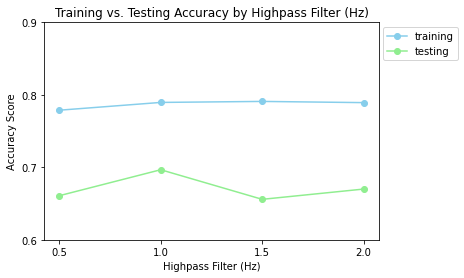

In [72]:
plt.plot(highpass_vals, training_accs, '-o', color = 'skyblue', label = 'training')
plt.plot(highpass_vals, testing_accs, '-o', color = 'lightgreen', label = 'testing')
plt.xlabel('Highpass Filter (Hz)')
plt.ylabel('Accuracy Score')
plt.xticks([0.5, 1.0, 1.5, 2.0])
plt.yticks([0.6, 0.7, 0.8, 0.9])
plt.title('Training vs. Testing Accuracy Score by Highpass Filter (Hz)')
plt.legend(bbox_to_anchor = (1.25, 1), loc = 'upper right')
plt.show()

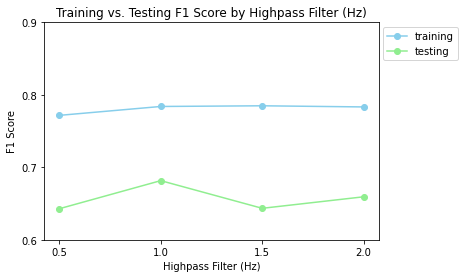

In [71]:
plt.plot(highpass_vals, training_macro_f1s, '-o', color = 'skyblue', label = 'training')
plt.plot(highpass_vals, testing_macro_f1s, '-o', color = 'lightgreen', label = 'testing')
plt.xlabel('Highpass Filter (Hz)')
plt.ylabel('F1 Score')
plt.xticks([0.5, 1.0, 1.5, 2.0])
plt.yticks([0.6, 0.7, 0.8, 0.9])
plt.title('Training vs. Testing F1 Score by Highpass Filter (Hz)')
plt.legend(bbox_to_anchor = (1.25, 1), loc = 'upper right')
plt.show()

### Lowpass Filtering

In [73]:
lowpass_values = [40, 50, 60, 70, 80, 90]

In [75]:
#for i in range(6):
#    feature_df = full_band_df(2000, activity_df_list, None, lowpass_values[i], bandpass = True, notch = False, reref = False)
#    feature_df.to_csv('lowpass_features_{}.csv'.format(i), index = None)

In [76]:
X0 = pd.read_csv('lowpass_features_0.csv')
X1 = pd.read_csv('lowpass_features_1.csv')
X2 = pd.read_csv('lowpass_features_2.csv')
X3 = pd.read_csv('lowpass_features_3.csv')
X4 = pd.read_csv('lowpass_features_4.csv')
X5 = pd.read_csv('lowpass_features_5.csv')

In [77]:
scaler0 = StandardScaler()
X0 = scaler0.fit_transform(X0)

scaler1 = StandardScaler()
X1 = scaler1.fit_transform(X1)

scaler2 = StandardScaler()
X2 = scaler2.fit_transform(X2)

scaler3 = StandardScaler()
X3 = scaler3.fit_transform(X3)

scaler4 = StandardScaler()
X4 = scaler4.fit_transform(X4)

scaler5 = StandardScaler()
X5 = scaler5.fit_transform(X5)

In [78]:
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y, test_size = 0.1)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size = 0.1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size = 0.1)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, test_size = 0.1)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y, test_size = 0.1)
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y, test_size = 0.1)

In [79]:
x_training_sets = [X0_train, X1_train, X2_train, X3_train, X4_train, X5_train]
x_testing_sets = [X0_test, X1_test, X2_test, X3_test, X4_test, X5_test]

In [80]:
y_training_sets = [y0_train, y1_train, y2_train, y3_train, y4_train, y5_train]
y_testing_sets = [y0_test, y1_test, y2_test, y3_test, y4_test, y5_test]

In [81]:
training_accs, training_macro_f1s, training_f1s = [], [], []
testing_accs, testing_macro_f1s, testing_f1s = [], [], []
for i in range(6):
    knn = KNeighborsClassifier()
    knn.fit(x_training_sets[i], y_training_sets[i])
    training_yhat = knn.predict(x_training_sets[i])
    testing_yhat = knn.predict(x_testing_sets[i])
    training_accs.append(accuracy_score(y_training_sets[i], training_yhat))
    training_macro_f1s.append(f1_score(y_training_sets[i], training_yhat, average = 'macro'))
    training_f1s.append(f1_score(y_training_sets[i], training_yhat, average = None))
    testing_accs.append(accuracy_score(y_testing_sets[i], testing_yhat))
    testing_macro_f1s.append(f1_score(y_testing_sets[i], testing_yhat, average = 'macro'))
    testing_f1s.append(f1_score(y_testing_sets[i], testing_yhat, average = None))

In [82]:
training_f1_activity = pd.DataFrame(training_f1s, index = ['40 Hz', '50 Hz', '60 Hz', '70 Hz', '80 Hz', '90 Hz'], columns = np.unique(y)).transpose()
testing_f1_activity = pd.DataFrame(testing_f1s, index = ['40 Hz', '50 Hz', '60 Hz', '70 Hz', '80 Hz', '90 Hz'], columns = np.unique(y)).transpose()

In [83]:
training_f1_activity.round(decimals = 3)

,40 Hz,50 Hz,60 Hz,70 Hz,80 Hz,90 Hz
GPD,0.852,0.852,0.855,0.860,0.867,0.857
GRDA,0.778,0.788,0.802,0.785,0.792,0.805
LPD,0.764,0.792,0.805,0.798,0.798,0.800
LRDA,0.842,0.827,0.842,0.841,0.833,0.838
Other,0.608,0.617,0.655,0.650,0.633,0.645
Seizure,0.666,0.695,0.729,0.728,0.721,0.703


In [84]:
testing_f1_activity.round(decimals = 3)

,40 Hz,50 Hz,60 Hz,70 Hz,80 Hz,90 Hz
GPD,0.748,0.757,0.745,0.755,0.762,0.770
GRDA,0.647,0.667,0.674,0.664,0.662,0.676
LPD,0.656,0.627,0.673,0.683,0.708,0.688
LRDA,0.746,0.737,0.764,0.751,0.726,0.744
Other,0.449,0.412,0.389,0.462,0.385,0.444
Seizure,0.542,0.522,0.561,0.562,0.559,0.555


In [85]:
overall_scores = pd.DataFrame(training_accs, index = ['40 Hz', '50 Hz', '60 Hz', '70 Hz', '80 Hz', '90 Hz'], columns = ['Training Accuracy'])

In [86]:
overall_scores['Training Macro F1'] = training_macro_f1s
overall_scores['Testing Accuracy'] = testing_accs
overall_scores['Testing Macro F1'] = testing_macro_f1s

### Notes on Results  
  
The best results here are 70 Hz and 90 Hz. They both mark about a 1% improvement in testing accuracy from the results before filtering. I'm going with 90 Hz for the lowpass filter instead of 70 Hz which was the recommendation from Learning EEG because a lowpass filter at 90 Hz filters out less data. When preprocessing EEG data, it's important to err on the side of caution because you don't want to distort the actual brain activity signals. The results of the 70 Hz and 90 Hz filters are nearly equivalent, so the best option is the one which filters out the least amount of data.

In [87]:
overall_scores.round(decimals = 3)

,Training Accuracy,Training Macro F1,Testing Accuracy,Testing Macro F1
40 Hz,0.761,0.751,0.643,0.631
50 Hz,0.770,0.762,0.637,0.620
60 Hz,0.787,0.781,0.653,0.634
70 Hz,0.783,0.777,0.658,0.646
80 Hz,0.781,0.774,0.648,0.634
90 Hz,0.783,0.775,0.660,0.646


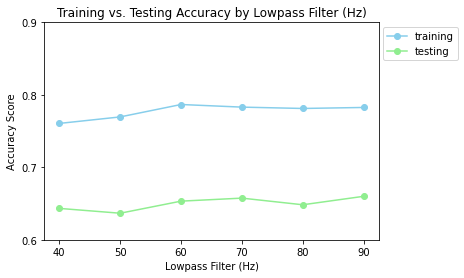

In [89]:
plt.plot(lowpass_values, training_accs, '-o', color = 'skyblue', label = 'training')
plt.plot(lowpass_values, testing_accs, '-o', color = 'lightgreen', label = 'testing')
plt.xlabel('Lowpass Filter (Hz)')
plt.ylabel('Accuracy Score')
plt.xticks([40, 50, 60, 70, 80, 90])
plt.yticks([0.6, 0.7, 0.8, 0.9])
plt.title('Training vs. Testing Accuracy by Lowpass Filter (Hz)')
plt.legend(bbox_to_anchor = (1.25, 1), loc = 'upper right')
plt.show()

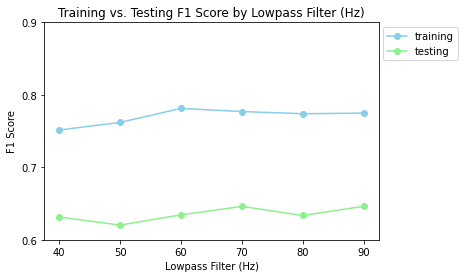

In [90]:
plt.plot(lowpass_values, training_macro_f1s, '-o', color = 'skyblue', label = 'training')
plt.plot(lowpass_values, testing_macro_f1s, '-o', color = 'lightgreen', label = 'testing')
plt.xlabel('Lowpass Filter (Hz)')
plt.ylabel('F1 Score')
plt.xticks([40, 50, 60, 70, 80, 90])
plt.yticks([0.6, 0.7, 0.8, 0.9])
plt.title('Training vs. Testing F1 Score by Lowpass Filter (Hz)')
plt.legend(bbox_to_anchor = (1.25, 1), loc = 'upper right')
plt.show()

### Bandpass (1, 90) Filter

In [98]:
#bandpass_190 = full_band_df(2000, activity_df_list, 1, 90, bandpass = True, notch = False, reref = False)
#bandpass_190.to_csv('bandpass_190.csv', index = None)

In [46]:
X = pd.read_csv('bandpass_190.csv')

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [47]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Training with Bandpass (1, 90)')
print(classification_report(y_train, training_yhat))
print('Testing with Bandpass (1, 90)')
print(classification_report(y_test, testing_yhat))

Training with Bandpass (1, 90)
              precision    recall  f1-score   support

         GPD       0.80      0.93      0.86      1794
        GRDA       0.73      0.88      0.79      1819
         LPD       0.75      0.86      0.80      1800
        LRDA       0.82      0.87      0.84      1795
       Other       0.77      0.56      0.65      1808
     Seizure       0.87      0.60      0.71      1784

    accuracy                           0.78     10800
   macro avg       0.79      0.78      0.78     10800
weighted avg       0.79      0.78      0.78     10800

Testing with Bandpass (1, 90)
              precision    recall  f1-score   support

         GPD       0.73      0.86      0.79       206
        GRDA       0.57      0.80      0.67       181
         LPD       0.61      0.76      0.68       200
        LRDA       0.74      0.77      0.76       205
       Other       0.49      0.28      0.36       192
     Seizure       0.83      0.50      0.62       216

    accuracy    

In [48]:
lowpass_train, lowpass_test = accuracy_score(y_train, training_yhat), accuracy_score(y_test, testing_yhat)

In [49]:
lowpass_train.round(decimals = 3), lowpass_test.round(decimals = 3)

(0.783, 0.662)

### Highpass Filter Only  
  
The lowpass filter at 90 Hz either doesn't improve results or hurts results slightly. In the interest of erring on the side of caution, it's best to not filter out data for no benefit.

In [14]:
#highpass_only = full_band_df(2000, activity_df_list, 1, None, bandpass = True, reref = False)
#highpass_only.to_csv('highpass_only_df.csv', index = None)

In [23]:
X = pd.read_csv('highpass_only_df.csv')
y = get_yvals(2000)['activity']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [24]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Training with Bandpass (Highpass at 1 Hz Only)')
print(classification_report(y_train, training_yhat))
print('Testing with Bandpass (Highpass at 1 Hz Only)')
print(classification_report(y_test, testing_yhat))

Training with Bandpass (Highpass at 1 Hz Only)
              precision    recall  f1-score   support

         GPD       0.80      0.92      0.86      1794
        GRDA       0.73      0.88      0.80      1819
         LPD       0.75      0.87      0.80      1800
        LRDA       0.82      0.87      0.85      1795
       Other       0.76      0.55      0.64      1808
     Seizure       0.88      0.62      0.73      1784

    accuracy                           0.78     10800
   macro avg       0.79      0.78      0.78     10800
weighted avg       0.79      0.78      0.78     10800

Testing with Bandpass (Highpass at 1 Hz Only)
              precision    recall  f1-score   support

         GPD       0.72      0.87      0.79       206
        GRDA       0.58      0.77      0.66       181
         LPD       0.70      0.80      0.74       200
        LRDA       0.73      0.83      0.78       205
       Other       0.53      0.35      0.42       192
     Seizure       0.72      0.42      